In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Activation, Conv2D, BatchNormalization, ReLU,\
                          LeakyReLU, Conv2DTranspose, Dropout, Input, Concatenate)

import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'
#path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=URL, extract=True)
#PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

PATH = '/home/maldonado/.keras/datasets/facades/'
INPATH = PATH + 'train/'
CKPATH = PATH + 'ckeckpoint/'

if not os.path.exists(CKPATH):
    os.makedirs(CKPATH)

print(INPATH)
print(CKPATH)

/home/maldonado/.keras/datasets/facades/train/
/home/maldonado/.keras/datasets/facades/ckeckpoint/


In [4]:
imgurls = !ls -1 "{INPATH}"
randurls = np.copy(imgurls)
np.random.shuffle(randurls)

n = len(imgurls)
tn = int(n * 0.8)

train_url = randurls[:tn]
test_url = randurls[tn:n]

print(train_url)
print(test_url)

['4.jpg' '2.jpg' '3.jpg' '5.jpg']
['1.jpg']


In [5]:
img_width = 256
img_height = 256

# Resize
def resize(inp, trg, h, w):
    inp = tf.image.resize(inp, [h,w])
    trg = tf.image.resize(trg, [h,w])
    
    return (inp, trg)
    
# Normalize
def normalize(inp, trg):
    inp = (inp / 127.5) - 1
    trg = (trg / 127.5) - 1
    
    return (inp, trg)

# Image Augmentation (Paper)
def random_jitter(inp, trg):
    inp, trg = resize(inp, trg, 286, 286)
    
    stacked_image = tf.stack([inp, trg], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, img_height, img_width, 3])
    
    inp, trg = cropped_image[0], cropped_image[1]
    
    if(tf.random.uniform(()) > 0.5):
        inp = tf.image.flip_left_right(inp)
        trg = tf.image.flip_left_right(trg)
        
    return (inp, trg)

def load(filename):
    image = tf.io.read_file(INPATH + filename)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    
    inp = image[:, w:, :]
    trg = image[:, :w, :]

    inp = tf.cast(inp, tf.float32)
    trg = tf.cast(trg, tf.float32)
    
    return (inp, trg)

def load_img(filename, augment=False):
    inp, trg = load(filename)
    inp, trg = resize(inp, trg, img_height, img_width)
    
    if(augment):
        inp, trg = random_jitter(inp, trg)
        
    inp, trg = normalize(inp, trg)
    
    return (inp, trg)

def load_train_img(filename):
    return load_img(filename, True)

def load_test_img(filename):
    return load_img(filename, False)

In [6]:
def plot_image(img):
    plt.subplot(121)
    plt.imshow((img[0]+1) / 2)

    plt.subplot(122)
    plt.imshow((img[1]+1) / 2)

    plt.show()

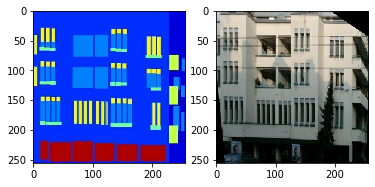

In [7]:
img = load_img(imgurls[0])
plot_image(img)

In [8]:
# Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_url)
train_dataset = train_dataset.map(load_train_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_url)
test_dataset = test_dataset.map(load_test_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

#for inp, trg in test_dataset.take(2):
#    plot_image((inp[0,...], trg[0,...]))

In [9]:
# Downsampling
def downsample(filters, batch=True):
    result = Sequential()
    
    init = tf.random_normal_initializer(0, 0.02)
    
    # Convolution Layer
    result.add(Conv2D(
        filters=filters,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=not batch
    ))
    
    if(batch):
        # Batch Norm Layer
        result.add(BatchNormalization())
    
    # Activation Layer
    result.add(LeakyReLU())
    
    return result

In [10]:
# Upsampling
def upsample(filters, drop=False):
    result = Sequential()
    
    init = tf.random_normal_initializer(0, 0.02)
    
    # Convolution Layer
    result.add(Conv2DTranspose(
        filters=filters,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=False
    ))
    
    # Batch Norm Layer
    result.add(BatchNormalization())
    
    if(drop):
        # Dropout Layer
        result.add(Dropout(0.5))
        
    # Activation Layer
    result.add(ReLU())
    
    return result

In [11]:
# Generator Network
def generator():
    
    inputs = Input(shape=[None, None, 3])
    
    down_stack = [
        downsample(64, batch=False), # (bs, 128, 128, 64)
        downsample(128),             # (bs, 64,  64,  256)
        downsample(256),             # (bs, 32,  32,  256)
        downsample(512),             # (bs, 16,  16,  512)
        downsample(512),             # (bs, 8,   8,   512)
        downsample(512),             # (bs, 4,   4,   512)
        downsample(512),             # (bs, 2,   2,   512)
        downsample(512)              # (bs, 1,   1,   512)
    ]
    
    up_stack = [
        upsample(512, drop=True),    # (bs, 2,   2,   1024)
        upsample(512, drop=True),    # (bs, 4,   4,   1024)
        upsample(512, drop=True),    # (bs, 8,   8,   1024)
        upsample(512),               # (bs, 16,  16,  1024)
        upsample(256),               # (bs, 32,  32,  512)
        upsample(128),               # (bs, 64,  64,  256)
        upsample(64)                 # (bs, 128, 128,   128)
    ]
    
    init = tf.random_normal_initializer(0, 0.02)
    
    # Last Layer
    last = Conv2DTranspose(
        filters=3,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=init,
        activation='tanh'
    )
    
    x = inputs
    s = []                    # Skip Connections
    concat = Concatenate()    # Concatenate [s,x]
    
    for down in down_stack:
        x = down(x)
        s.append(x)
        
    s = reversed(s[:-1])
        
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
        
    x = last(x)
    
    return Model(inputs=inputs, outputs=x)

#gen = generator()
#gen_out = gen(((img[0] + 1) / 2)[tf.newaxis,...], training=False)

In [12]:
# Discriminator Network
def discriminator():
    ini = Input(shape=[None, None, 3], name='input_img')
    gen = Input(shape=[None, None, 3], name='gener_img')
    
    con = Concatenate()([ini, gen])
    init = tf.random_normal_initializer(0, 0.02)
    
    down1 = downsample(64, batch=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = Conv2D(
        filters=1,
        kernel_size=4,
        strides=1,
        padding='same',
        kernel_initializer=init
    )(down4)
    
    return Model(inputs=[ini,gen], outputs=last)

#disc = discriminator()
#disc_out = disc([((img[0] + 1) / 2)[tf.newaxis,...], gen_out], training=False)

In [13]:
# Loss
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)

    total_disc_loss = real_loss + gen_loss

    return total_disc_loss
    
LAMBDA = 100
def generator_loss(disc_gen_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_gen_output), disc_gen_output)

    # Mean Absolute Error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [14]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gen = generator()
disc = discriminator()

In [16]:
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen,
                                 discriminator=disc)

#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [17]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    
    plt.figure(figsize=(10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [18]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        out_img = gen(input_image, training=True)
        out_gen_disc = disc([out_img, input_image], training=True)
        out_trg_disc = disc([target, input_image], training=True)

        disc_loss = discriminator_loss(out_trg_disc, out_gen_disc)
        gen_loss = generator_loss(out_gen_disc, out_img, target)
        
        gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, disc.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

In [19]:
from IPython.display import clear_output

def train(dataset, epochs):
    
    for ep in range(epochs):
        img1 = 0
        for input_img, target in dataset:
            print('epoch {} - train: {}/{}'.format(ep, img1, len(train_url)))
            img1 += 1
            train_step(input_img, target)
            clear_output(wait=True)
            
        if((ep + 1) % 2 == 0):
            checkpoint.save(file_prefix=checkpoint_prefix)

In [20]:
train(train_dataset, 20)

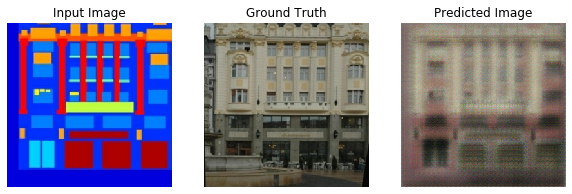

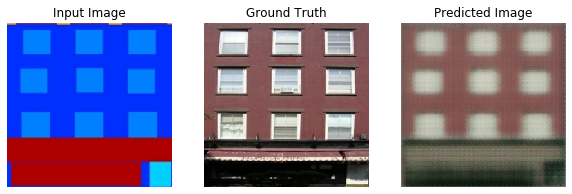

In [40]:
for inp, tar in (train_dataset.shuffle(5)).take(2):
    generate_images(gen, inp, tar)